# Import of Librerie

In [1]:
import zipfile
import os

from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import shutil
import cv2

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.transforms import ToPILImage

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset

In [3]:
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/only_landmarks.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

# Data Mangement

In [11]:
output_path = '/content/sample_data/only_landmarks/nothing'

os.makedirs(output_path, exist_ok=True)

# Dimension of images
width, height = 640, 480

# num images to create
num_images = 600

for i in range(num_images):

    white_image = np.ones((height, width, 3), dtype=np.uint8) * 255
    image_path = os.path.join(output_path, f'white_image_{i+1}.png')

    cv2.imwrite(image_path, white_image)

print(f"Created {num_images} white images in '{output_path}'")


Created 600 white images in '/content/sample_data/only_landmarks/nothing'


In [12]:
def create_folders(base_path, categories):
    for category in categories:
        os.makedirs(os.path.join(base_path, category), exist_ok=True)

def count_images_in_subfolders(base_path, categories):
    counts = {}
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            counts[category] = len(os.listdir(category_path))
    return counts

def print_image_counts(counts, folder_name):
    print(f"Image counts in {folder_name} folder:")
    for category, count in counts.items():
        print(f"{category}: {count}")
    print()

def split_dataset(dataset_path, train_path, val_path, test_path, split_ratio=(0.9, 0.05, 0.05)):
    categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    create_folders(train_path, categories)
    create_folders(val_path, categories)
    create_folders(test_path, categories)

    original_counts = count_images_in_subfolders(dataset_path, categories)
    print_image_counts(original_counts, 'original dataset')

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images = os.listdir(category_path)

        random.shuffle(images)

        train_end = int(len(images) * split_ratio[0])
        val_end = train_end + int(len(images) * split_ratio[1])

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        for image in train_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(train_path, category, image))
        for image in val_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(val_path, category, image))
        for image in test_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(test_path, category, image))

    train_counts = count_images_in_subfolders(train_path, categories)
    val_counts = count_images_in_subfolders(val_path, categories)
    test_counts = count_images_in_subfolders(test_path, categories)

    print_image_counts(train_counts, 'train')
    print_image_counts(val_counts, 'validation')
    print_image_counts(test_counts, 'test')

if __name__ == "__main__":
    dataset_path = '/content/sample_data/only_landmarks'
    train_path = '/content/sample_data/DATA/train'
    val_path = '/content/sample_data/DATA/validation'
    test_path = '/content/sample_data/DATA/test'

    split_dataset(dataset_path, train_path, val_path, test_path)


Image counts in original dataset folder:
A: 600
S: 602
T: 601
G: 601
J: 601
K: 601
F: 601
W: 601
N: 601
V: 601
L: 601
Q: 601
E: 601
space: 601
I: 601
Y: 601
M: 601
D: 601
R: 601
X: 601
nothing: 600
del: 590
Z: 601
C: 601
H: 601
O: 601
U: 601
B: 601
P: 601

Image counts in train folder:
A: 540
S: 541
T: 540
G: 540
J: 540
K: 540
F: 540
W: 540
N: 540
V: 540
L: 540
Q: 540
E: 540
space: 540
I: 540
Y: 540
M: 540
D: 540
R: 540
X: 540
nothing: 540
del: 531
Z: 540
C: 540
H: 540
O: 540
U: 540
B: 540
P: 540

Image counts in validation folder:
A: 30
S: 30
T: 30
G: 30
J: 30
K: 30
F: 30
W: 30
N: 30
V: 30
L: 30
Q: 30
E: 30
space: 30
I: 30
Y: 30
M: 30
D: 30
R: 30
X: 30
nothing: 30
del: 29
Z: 30
C: 30
H: 30
O: 30
U: 30
B: 30
P: 30

Image counts in test folder:
A: 30
S: 31
T: 31
G: 31
J: 31
K: 31
F: 31
W: 31
N: 31
V: 31
L: 31
Q: 31
E: 31
space: 31
I: 31
Y: 31
M: 31
D: 31
R: 31
X: 31
nothing: 30
del: 30
Z: 31
C: 31
H: 31
O: 31
U: 31
B: 31
P: 31



In [13]:
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# directory path
train_path = '/content/sample_data/DATA/train'
val_path = '/content/sample_data/DATA/validation'
test_path = '/content/sample_data/DATA/test'

# load dataset
train_data = ImageFolder(root=train_path, transform=transform)
val_data = ImageFolder(root=val_path, transform=transform)
test_data = ImageFolder(root=test_path, transform=transform)

# size batch
batch_size = 16

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
directory_to_clear = Path('/content/sample_data/DATA')

def clear_directory(directory_path):
    if directory_path.exists() and directory_path.is_dir():
        shutil.rmtree(directory_path)
        print(f"All sub-folder {directory_path} was eliminated.")
        directory_path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"The directory {directory_path} doesn't exist or is not valid.")

#clear_directory(directory_to_clear)

All sub-folder /content/sample_data/DATA was eliminated.


# CNN

In [15]:
# Define the CNN using nn.Module
class HandGestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(HandGestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)

        # Compute the size of the input to the first fully connected layer
        # After three pooling layers with kernel_size=2 and stride=2, the spatial dimensions are reduced by a factor of 8
        # (480 / 2 / 2 / 2) = 60
        self.fc1 = nn.Linear(128 * 80 * 60, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        x = x.view(-1, 128 * 80 * 60)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
num_classes = len(train_data.classes)
model = HandGestureCNN(num_classes=29)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

HandGestureCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=614400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=29, bias=True)
)

# Train

In [18]:
train_losses = []
val_losses = []
val_accuracies = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader, desc=f'{phase} Epoch {epoch}/{num_epochs - 1}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

save_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/2_only_landmarks_hand_gesture_cnn_with_metrics.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, save_path)

print(f"Modello e metriche salvate con successo in {save_path}.")

Epoch 0/4
----------


train Loss: 1.1207 Acc: 0.7419


val Loss: 0.0645 Acc: 0.9850
Epoch 1/4
----------


train Loss: 0.1114 Acc: 0.9681


val Loss: 0.0350 Acc: 0.9919
Epoch 2/4
----------


train Loss: 0.0615 Acc: 0.9812


val Loss: 0.0278 Acc: 0.9954
Epoch 3/4
----------


train Loss: 0.0543 Acc: 0.9840


val Loss: 0.0216 Acc: 0.9942
Epoch 4/4
----------


train Loss: 0.0401 Acc: 0.9882


val Loss: 0.0097 Acc: 0.9954
Best val Acc: 0.9954
Modello e metriche salvate con successo in /content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/2_only_landmarks_hand_gesture_cnn_with_metrics.pth.


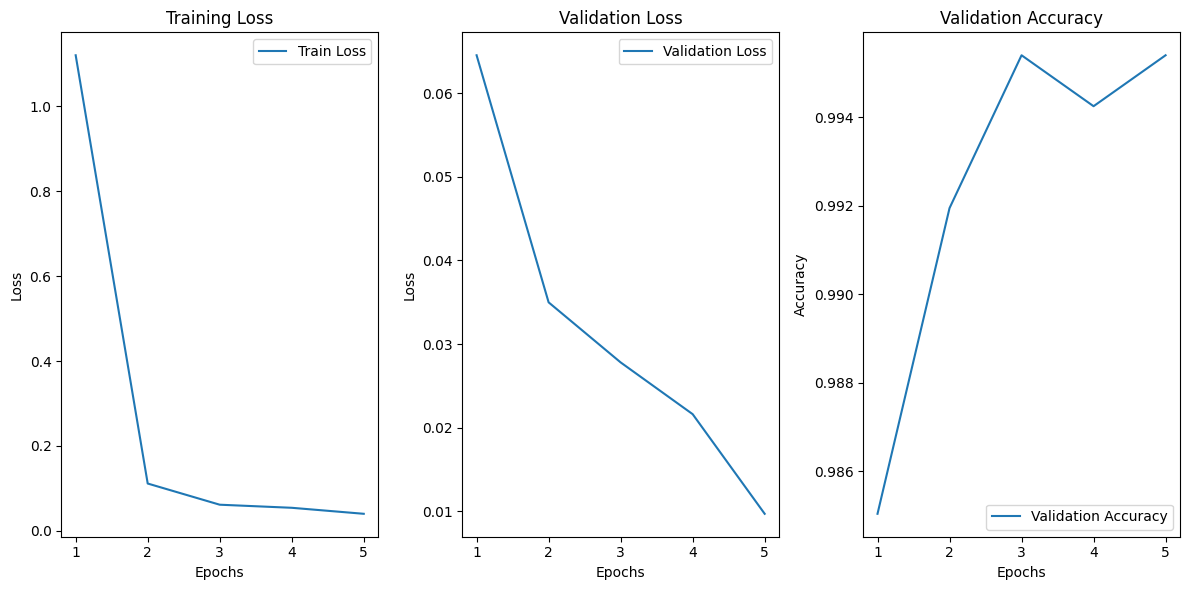

In [19]:
file_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/2_only_landmarks_hand_gesture_cnn_with_metrics.pth'

checkpoint = torch.load(file_path, map_location=torch.device('cpu'))

train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

if isinstance(val_accuracies[0], torch.Tensor):
    val_accuracies = [acc.cpu().numpy() for acc in val_accuracies]


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot validation loss
plt.subplot(1, 3, 2)
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Test of CNN

Accuracy: 0.9922
Precision: 0.9925
Recall: 0.9922
F1 Score: 0.9921
Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        30
           B       1.00      1.00      1.00        31
           C       1.00      1.00      1.00        31
           D       1.00      0.97      0.98        31
           E       0.97      1.00      0.98        31
           F       1.00      1.00      1.00        31
           G       1.00      0.97      0.98        31
           H       1.00      1.00      1.00        31
           I       1.00      1.00      1.00        31
           J       1.00      1.00      1.00        31
           K       1.00      1.00      1.00        31
           L       1.00      1.00      1.00        31
           M       0.97      1.00      0.98        31
           N       1.00      0.87      0.93        31
           O       1.00      1.00      1.00        31
           P       1.00      1.00      1.00  

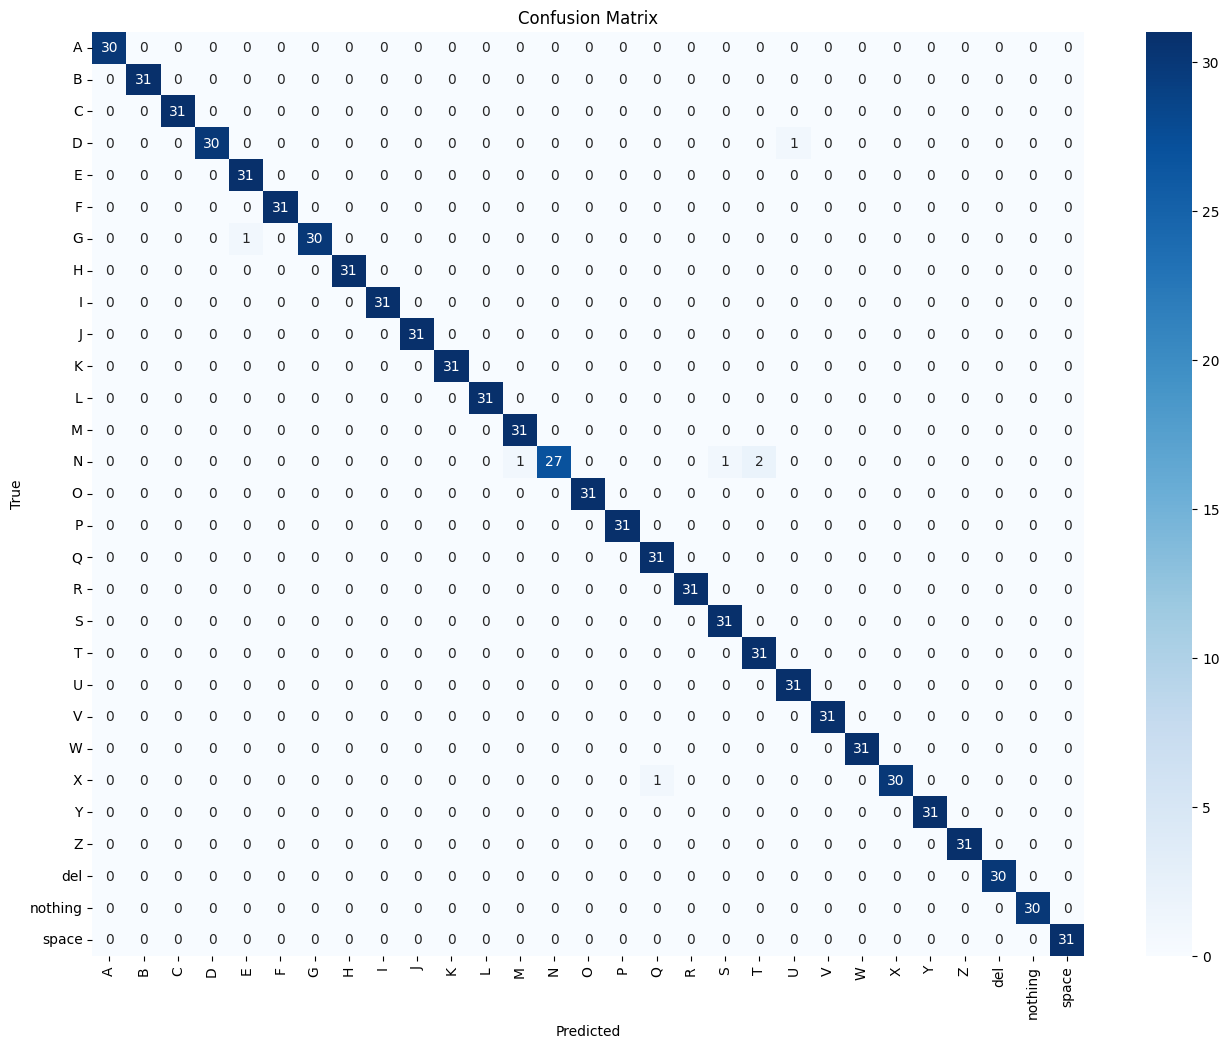

In [20]:
model_path = '/content/drive/MyDrive/Computer Vision/PROJECT/dataset_hand_gesture/hand_craft_dataset/2_only_landmarks_hand_gesture_cnn_with_metrics.pth'
num_classes = len(test_data.classes)
model = HandGestureCNN(num_classes=29)

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def calculate_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=test_data.classes)

    accuracy = np.sum(all_preds == all_labels) / len(all_labels)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

    plt.figure(figsize=(16, 12))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Esegui il calcolo delle metriche
calculate_metrics(model, test_loader)